Target: Add batch normalization to increase efficiency <br>

Results: <br>
Parameters: 8,680 (<10K) <br> <br>
Best Training Accuracy: 99.75 <br>
Best Test Accuracy: 99.15 <br>

Analysis: <br>
Good model, train, test accuracy increased over previous experiment <br>
Can still increase few layers/filters to increase accuracy to touch 99.4 <br>

In [1]:
!pip install torchsummary

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -28 Output- 26 RF 3
        self.b1c1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, 1, padding=0)
        self.b2c2 = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(20, 20, 1, padding=0)
        self.b3c3 = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 20, 3, padding=1)
        self.b4c4 = nn.BatchNorm2d(20)
        self.pool2 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.AdaptiveAvgPool2d(7)
        self.conv5 = nn.Conv2d(20, 10, 3)
        self.b5c5 = nn.BatchNorm2d(10)
        self.conv6 = nn.Conv2d(10, 10, 5)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.pool1(F.relu(self.b2c2(self.conv2(F.relu(self.b1c1(self.conv1(x)))))))
        x = self.pool2(F.relu(self.b4c4(self.conv4(F.relu(self.b3c3(self.conv3(x)))))))
        x = F.relu(self.conv6(F.relu(self.b5c5(self.conv5(x)))))
        #x = F.relu(self.conv7(x))
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [9]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
       BatchNorm2d-2           [-1, 10, 28, 28]              20
            Conv2d-3           [-1, 20, 28, 28]             220
       BatchNorm2d-4           [-1, 20, 28, 28]              40
         MaxPool2d-5           [-1, 20, 14, 14]               0
            Conv2d-6           [-1, 20, 14, 14]             420
       BatchNorm2d-7           [-1, 20, 14, 14]              40
            Conv2d-8           [-1, 20, 14, 14]           3,620
       BatchNorm2d-9           [-1, 20, 14, 14]              40
        MaxPool2d-10             [-1, 20, 7, 7]               0
           Conv2d-11             [-1, 10, 5, 5]           1,810
      BatchNorm2d-12             [-1, 10, 5, 5]              20
           Conv2d-13             [-1, 10, 1, 1]           2,510
Total params: 8,840
Trainable params: 8

In [10]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_losses.append(loss)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_loss /= len(train_loader.dataset)
    train_accuracy.append(100*correct/len(train_loader.dataset))

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            processed += len(data)

             
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracy.append(100*correct/len(test_loader.dataset)) 
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("\nEpoch: ",epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


Epoch:  1


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]c:\users\ktgan\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.07893072813749313 batch_id=468 Accuracy = 90.91: 100%|████████████████████████| 469/469 [00:18<00:00, 24.74it/s]



Train set: Average loss: 0.3072, Accuracy: 54543/60000 (90.91%)

Test set: Average loss: 0.0607, Accuracy: 9822/10000 (98.22%)


Epoch:  2


loss=0.038249026983976364 batch_id=468 Accuracy = 98.36: 100%|███████████████████████| 469/469 [00:16<00:00, 28.13it/s]



Train set: Average loss: 0.0544, Accuracy: 59015/60000 (98.36%)

Test set: Average loss: 0.0494, Accuracy: 9848/10000 (98.48%)


Epoch:  3


loss=0.05760137736797333 batch_id=468 Accuracy = 98.77: 100%|████████████████████████| 469/469 [00:17<00:00, 26.63it/s]



Train set: Average loss: 0.0406, Accuracy: 59263/60000 (98.77%)

Test set: Average loss: 0.0382, Accuracy: 9872/10000 (98.72%)


Epoch:  4


loss=0.04126375541090965 batch_id=468 Accuracy = 99.01: 100%|████████████████████████| 469/469 [00:17<00:00, 27.41it/s]



Train set: Average loss: 0.0327, Accuracy: 59405/60000 (99.01%)

Test set: Average loss: 0.0335, Accuracy: 9893/10000 (98.93%)


Epoch:  5


loss=0.01706545054912567 batch_id=468 Accuracy = 99.18: 100%|████████████████████████| 469/469 [00:16<00:00, 28.78it/s]



Train set: Average loss: 0.0282, Accuracy: 59507/60000 (99.18%)

Test set: Average loss: 0.0297, Accuracy: 9890/10000 (98.90%)


Epoch:  6


loss=0.007015526294708252 batch_id=468 Accuracy = 99.26: 100%|███████████████████████| 469/469 [00:16<00:00, 28.55it/s]



Train set: Average loss: 0.0238, Accuracy: 59558/60000 (99.26%)

Test set: Average loss: 0.0307, Accuracy: 9893/10000 (98.93%)


Epoch:  7


loss=0.011597405187785625 batch_id=468 Accuracy = 99.35: 100%|███████████████████████| 469/469 [00:16<00:00, 27.90it/s]



Train set: Average loss: 0.0217, Accuracy: 59608/60000 (99.35%)

Test set: Average loss: 0.0361, Accuracy: 9887/10000 (98.87%)


Epoch:  8


loss=0.027849486097693443 batch_id=468 Accuracy = 99.46: 100%|███████████████████████| 469/469 [00:15<00:00, 29.70it/s]



Train set: Average loss: 0.0190, Accuracy: 59678/60000 (99.46%)

Test set: Average loss: 0.0300, Accuracy: 9898/10000 (98.98%)


Epoch:  9


loss=0.030954187735915184 batch_id=468 Accuracy = 99.45: 100%|███████████████████████| 469/469 [00:16<00:00, 27.81it/s]



Train set: Average loss: 0.0175, Accuracy: 59673/60000 (99.45%)

Test set: Average loss: 0.0298, Accuracy: 9896/10000 (98.96%)


Epoch:  10


loss=0.0012194415321573615 batch_id=468 Accuracy = 99.58: 100%|██████████████████████| 469/469 [00:17<00:00, 27.23it/s]



Train set: Average loss: 0.0150, Accuracy: 59748/60000 (99.58%)

Test set: Average loss: 0.0292, Accuracy: 9902/10000 (99.02%)


Epoch:  11


loss=0.0021917622070759535 batch_id=468 Accuracy = 99.61: 100%|██████████████████████| 469/469 [00:16<00:00, 28.37it/s]



Train set: Average loss: 0.0136, Accuracy: 59766/60000 (99.61%)

Test set: Average loss: 0.0288, Accuracy: 9901/10000 (99.01%)


Epoch:  12


loss=0.010825772769749165 batch_id=468 Accuracy = 99.63: 100%|███████████████████████| 469/469 [00:16<00:00, 28.17it/s]



Train set: Average loss: 0.0130, Accuracy: 59777/60000 (99.63%)

Test set: Average loss: 0.0263, Accuracy: 9912/10000 (99.12%)


Epoch:  13


loss=0.005186805967241526 batch_id=468 Accuracy = 99.72: 100%|███████████████████████| 469/469 [00:17<00:00, 26.73it/s]



Train set: Average loss: 0.0111, Accuracy: 59831/60000 (99.72%)

Test set: Average loss: 0.0298, Accuracy: 9897/10000 (98.97%)


Epoch:  14


loss=0.007485071662813425 batch_id=468 Accuracy = 99.75: 100%|███████████████████████| 469/469 [00:18<00:00, 25.04it/s]



Train set: Average loss: 0.0097, Accuracy: 59848/60000 (99.75%)

Test set: Average loss: 0.0255, Accuracy: 9916/10000 (99.16%)


Epoch:  15


loss=0.002009014366194606 batch_id=468 Accuracy = 99.75: 100%|███████████████████████| 469/469 [00:16<00:00, 29.29it/s]



Train set: Average loss: 0.0091, Accuracy: 59849/60000 (99.75%)

Test set: Average loss: 0.0272, Accuracy: 9915/10000 (99.15%)



Text(0.5, 1.0, 'Test_Accuracy')

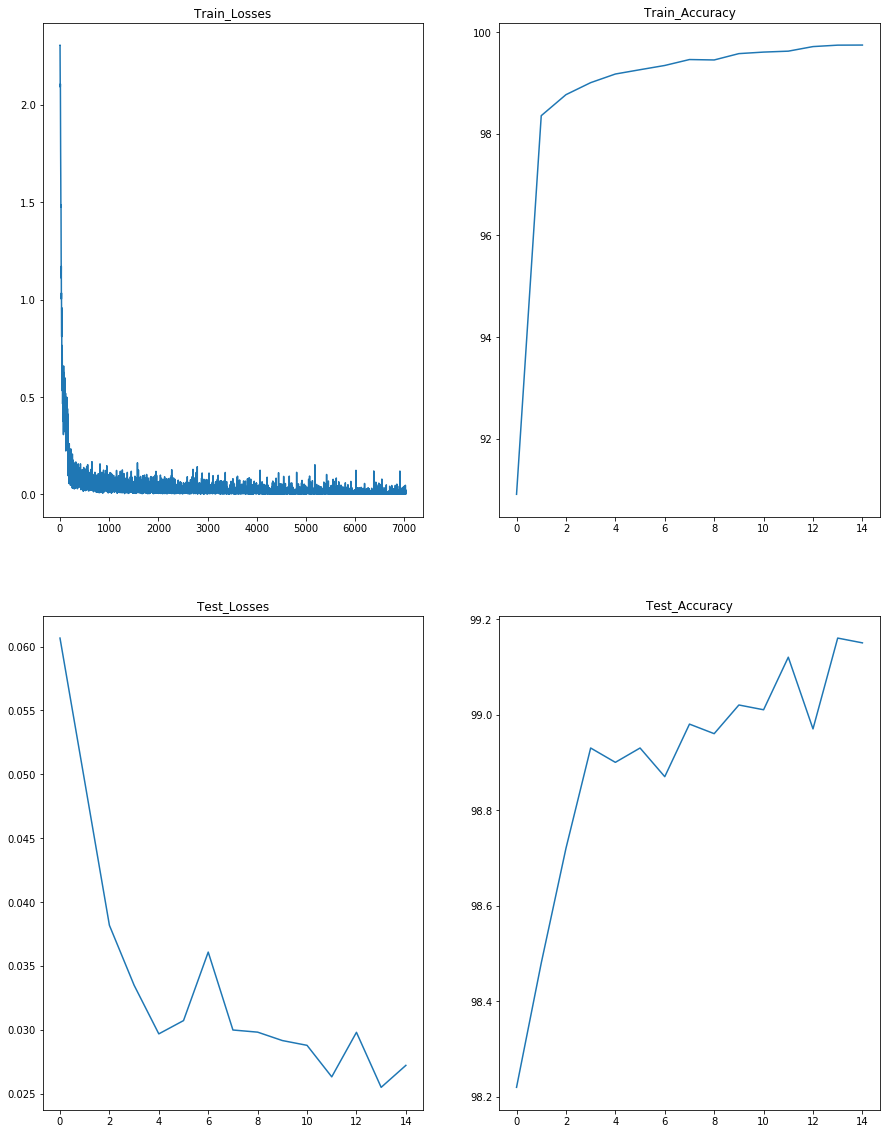

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(2,2,figsize=(15,20))
ax[0,0].plot(train_losses)
ax[0,0].set_title('Train_Losses')
ax[0,1].plot(train_accuracy)
ax[0,1].set_title('Train_Accuracy')

ax[1,0].plot(test_losses)
ax[1,0].set_title('Test_Losses')
ax[1,1].plot(test_accuracy)
ax[1,1].set_title('Test_Accuracy')